<h1 align="center"><font color='#964B00'>Table des matières</font></h1>

[0. Chargement et exploration des jeux de donnéest](#0)
 

[1. Partie 1: Recommendations](#1)

*    [2.1 Par popularité ](#1_1)
*    [2.1 Par similarité des étapes ou de la description](#1_3)

[2. Partie 2: Analyse de sentiments](#2)

*    [2.1 Extraction de features...](#2_1)
*    [2.1 Explicabilité](#2_5)

[3. Partie 3: Neural Collaborative Filtering](#3)



In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

<a id="0"></a> <br>
# 0. Chargement des différents jeux de données

In [2]:
interactions_train = pd.read_csv("data/interactions_train.csv")
interactions_test = pd.read_csv("data/interactions_test.csv") # On charge les données test car on ne fait pas de prédiction de score
raw_recipes = pd.read_csv("data/RAW_recipes.csv").sort_values(by="id")

In [3]:
# On retire les avis sans note
interactions_train.dropna(subset=['rating'], inplace=True)
interactions_test.dropna(subset=['rating'], inplace=True)

In [4]:
# Variable dummy juste pour la représentation graphique
interactions_test["test"] = True
interactions_train["test"] = False

In [5]:
interactions = pd.concat((interactions_train, interactions_test), ignore_index=True).sort_values(by="recipe_id")

<a id="0.1"></a> <br>

# 0. Exploration des données

<div style="border-radius:10px; border:#DEB887 solid; padding: 2px; background-color: #FFFAF0; font-size:100%; text-align:left; color:black">

Après visualiser la répartition des données, on remarque que la majorité des données provient du set d'entraînement. 

Deuxièmement, près de $75\%$ des avis sont des $5$ étoiles, on va donc avoir une moyenne des avis très haute, ce qui risque de perturber notre score.

In [6]:
print(f"Pourcentage de données d'entraînement : {len(interactions_train)/len(interactions)*100:.3}%", )

Pourcentage de données d'entraînement : 98.2%


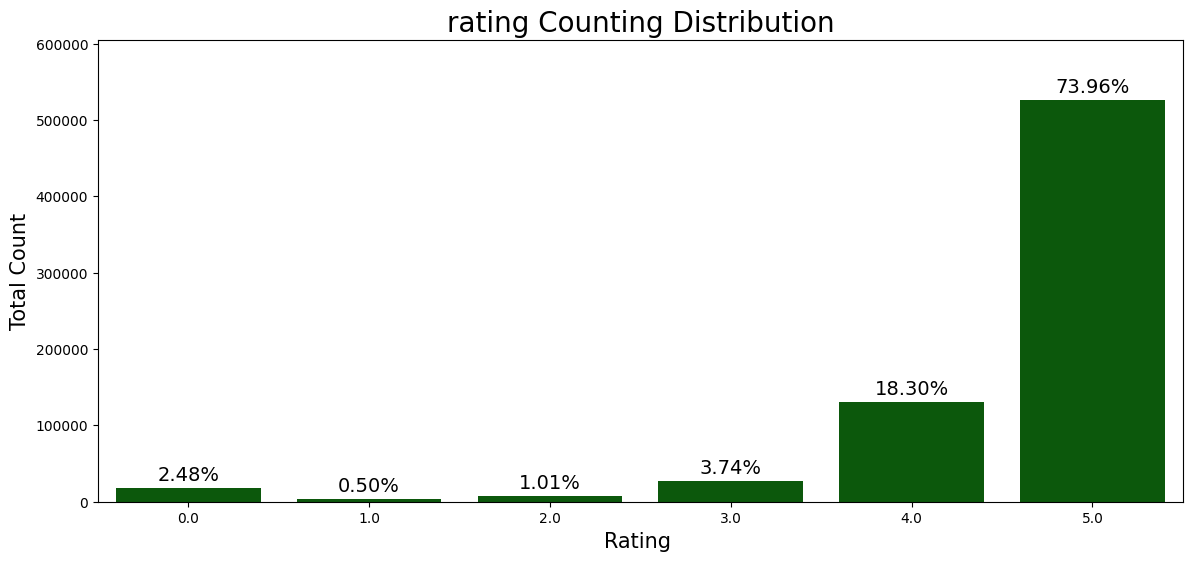

In [7]:
total = len(interactions)
plt.figure(figsize=(14,6))

g = sns.countplot(x='rating', color='darkgreen',
                  data=interactions)
g.set_title("rating Counting Distribution", fontsize=20)
g.set_xlabel("Rating ", fontsize=15)
g.set_ylabel("Total Count", fontsize=15)

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 10000,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

Visualisation du nombre de recettes publiés par an

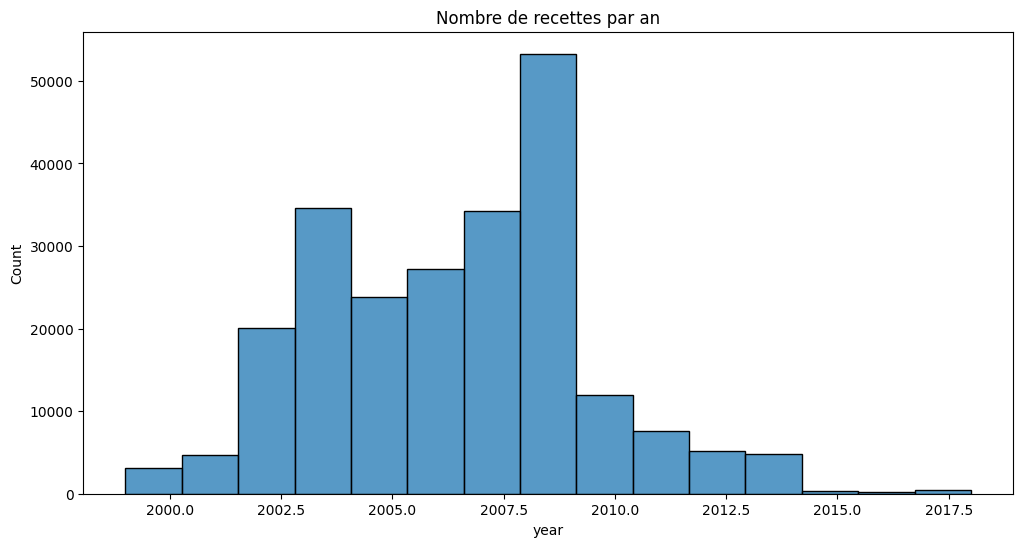

In [8]:
raw_recipes["year"] = raw_recipes["submitted"].str.split("-", expand = True)[0]
raw_recipes["year"] = raw_recipes["year"].fillna(-1).astype(int).replace(-1, np.nan)

plt.figure(figsize=(12,6))
sns.histplot(data=raw_recipes, x="year", bins = 15)
plt.title("Nombre de recettes par an")
plt.show()

<a id="1"></a> <br>
# Partie 1: Recommandations par popularité

<a id="1.1"></a> <br>
## 1.1 Regroupement des votes par recettes et calcul du score IMDb
On va créer un *DataFrame* regroupant la moyenne et le nombre de vote par recettes avec une base de 0 s'il n'y pas d'avis.

In [9]:
recipes_tab = pd.DataFrame(index=raw_recipes["id"].unique(), columns=["vote_average", "vote_count"]).sort_index()
group = interactions[["recipe_id", "rating"]].groupby("recipe_id")
recipes_tab.vote_count = group.count()
recipes_tab.vote_average = group.mean()
recipes_tab.fillna(0, inplace=True)

💡 __Remarque__

<div style="border-radius:10px; border:#DEB887 solid; padding: 2px; background-color: #FFFAF0; font-size:100%; text-align:left; color:black">

On peut voir sur l'histogramme ci-dessous que la grande majorité des recettes ne possède que quelques avis avec 60k n'en possédant aucun et 80k seulement 1 (sur 231k recettes).

In [10]:
px.histogram(recipes_tab, "vote_count", log_y=True, log_x=False)

💡 __Remarque__
<div style="border-radius:10px; border:#DEB887 solid; padding: 2px; background-color: #FFFAF0; font-size:100%; text-align:left; color:black">

Pour le score IMDb on va choisir `m` tel que seulement $10\%$ des recettes possèdent plus de `m` avis.

In [11]:
m = recipes_tab.vote_count.quantile(0.9) 
c = (recipes_tab.vote_average*recipes_tab.vote_count).sum()/recipes_tab.vote_count.sum()

recipes_tab['imdb_score'] = (recipes_tab.vote_count/(recipes_tab.vote_count+m))*recipes_tab.vote_average+(m/(m+recipes_tab.vote_count))*c
recipes_tab.sort_values(by='imdb_score', ascending=False, inplace=True)
recipes_tab

vote_average  vote_count  imdb_score
186029      5.000000        56.0    4.958171
55309       5.000000        48.0    4.951974
107059      5.000000        39.0    4.942369
166669      5.000000        35.0    4.936747
153877      5.000000        34.0    4.935165
...              ...         ...         ...
179740      2.000000         9.0    3.027108
461088      0.500000         4.0    2.940661
174348      0.800000         5.0    2.855147
31510       0.250000         4.0    2.840661
58947       0.714286         7.0    2.492817

[231637 rows x 3 columns]

<a id="1.2"></a> <br>
## 1.2 Définition dataset avec popularité intégrée

On va maintenant joindre ce dataframe de score avec le dataset contenant les informations globales sur les recettes afin de pouvoir choisir les recettes les plus populaires en fonction de certains critères (tags, durée, ingrédients, ...)

In [12]:
recipes_with_rating = raw_recipes.join(recipes_tab, on=["id"], how='left', validate='1:1')
recipes_with_rating.sort_values(by='imdb_score', ascending=False, inplace=True, ignore_index=True)

On définit une simple fonction pour pouvoir filtrer notre dataset en fonction d'une liste d'items sur une colonne en particulier.

In [13]:
def wrapper(filters_list, column_list):
    """
    Wrapper returning a filter function to pass to apply.
    filters_list: List of List of string we want in the columns
    column_lsit: List of columns to filter on
    Exemple: 
    >>> filter_fn = wrapper([["zucchini","goat cheese"], ['vegetarian']], ["ingredients", "tags"])
    >>> recipes_with_rating[recipes_with_rating.apply(filter_fn, axis=1)]
    >>> # will return recipes with zucchini and goat cheese in the ingredients column and vegetarian in the tags one
    """
    def filter_fn(row):
        return all([all([e in row[column] for e in filters]) for filters, column in zip(filters_list, column_list)])
    return filter_fn

In [14]:
def get_best_recipes(df, number=1, ingredients=[], tags=[]):
    if ingredients == []:
        if tags == []:
            return df.head(number)
        else:
            filter_fn = wrapper([tags], ["tags"])
    else:
        if tags == []:
            filter_fn = wrapper([ingredients], ["ingredients"])
        else:
            filter_fn = wrapper([ingredients, tags], ["ingredients", "tags"])
    return df[df.apply(filter_fn, axis=1)].head(number)


On peut maintenant facilement récupérer les 5 recettes végétariennes les plus populaires utilisant des courgettes et du chèvre.

In [24]:
best_recipes = get_best_recipes(recipes_with_rating, 5, ["zucchini","goat cheese"], ['vegetarian'])
best_recipes

name      id  minutes  \
7557                             taste of summer salad  432217       15   
22515        ratatouille inspired by the animated film  392997       80   
33624  zucchini and goat cheese stuffed sweet potatoes   44215       40   
41808                         creamy zucchini crostini  432165       22   
52143                                 moroccan missile  430702       65   

       contributor_id   submitted  \
7557            37449  2010-07-06   
22515          799208  2009-10-05   
33624            3288  2002-10-25   
41808          573325  2010-07-06   
52143           37449  2010-06-22   

                                                    tags  \
7557   ['weeknight', '15-minutes-or-less', 'time-to-m...   
22515  ['time-to-make', 'course', 'main-ingredient', ...   
33624  ['60-minutes-or-less', 'time-to-make', 'course...   
41808  ['30-minutes-or-less', 'time-to-make', 'course...   
52143  ['weeknight', 'time-to-make', 'course', 'main-...   

                                        nutrition  n_steps  \
7557        [40.9, 0.0, 14.0, 0.0, 4.0, 0.0, 2.0]        5   
22515     [143.1, 11.0, 37.0, 1.0, 7.0, 5.0, 6.0]       11   
33624     [181.8, 9.0, 29.0, 7.0, 7.0, 5.0, 10.0]       11   
41808   [225.0, 5.0, 13.0, 15.0, 18.0, 5.0, 13.0]        8   
52143  [330.9, 15.0, 44.0, 15.0, 18.0, 8.0, 17.0]       15   

                                                   steps  \
7557   ['mix all the veggies and herbs in a bowl', 'p...   
22515  ['preheat oven to 375 degrees f', 'in a large ...   
33624  ['bake or microwave the sweet potatoes until d...   
41808  ['heat the olive oil in a non-stick skillet', ...   
52143  ['preheat oven to 400f', 'mix the tomato paste...   

                                             description  \
7557   i made this using what fresh vegetables i had ...   
22515  this recipe is from the christian science moni...   
33624  the cheese contrasts wonderfully with the subt...   
41808  this is a wonderful appetiser, originally from...   
52143  this wrap pays homage to couscous, and is wond...   

                                             ingredients  n_ingredients  year  \
7557   ['tomatoes', 'zucchini', 'yellow squash', 'fre...             12  2010   
22515  ['tomato puree', 'garlic cloves', 'onion', 'ex...             11  2009   
33624  ['sweet potatoes', 'margarine', 'zucchini', 's...              6  2002   
41808  ['olive oil', 'zucchini', 'onion', 'garlic clo...              7  2010   
52143  ['tomato paste', 'red wine vinegar', 'olive oi...             16  2010   

       vote_average  vote_count  imdb_score  
7557            5.0         5.0    4.764238  
22515           5.0         3.0    4.711846  
33624           5.0         2.0    4.675827  
41808           4.8         5.0    4.673329  
52143           5.0         1.0    4.629516

In [18]:
best_recipes["ingredients"].iloc[0], best_recipes["tags"].iloc[0]

("['tomatoes', 'zucchini', 'yellow squash', 'fresh corn', 'green onions', 'red bell pepper', 'fresh basil', 'fresh oregano', 'fresh thyme', 'fresh parsley', 'goat cheese', 'red wine vinaigrette']",
 "['weeknight', '15-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'salads', 'vegetables', 'american', 'southern-united-states', 'summer', 'vegan', 'vegetarian', 'dietary', 'seasonal', 'squash', 'tomatoes']")

Ou alors la meilleure recette française de cookie au chocolat.

In [20]:
best_recipes = get_best_recipes(recipes_with_rating, 1, ["chocolate"], ['cookie', 'french'])

In [23]:
best_recipes["ingredients"].iloc[0], best_recipes["tags"].iloc[0]

('[\'white flour\', \'unsweetened cocoa powder\', \'baking powder\', \'sea salt\', \'unsalted butter\', \'dark brown sugar\', \'white sugar\', \'eggs\', \'pure vanilla extract\', \'dark chocolate chips\', \'bittersweet chocolate\', "confectioners\' sugar"]',
 "['weeknight', '30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'hand-formed-cookies', 'desserts', 'eggs-dairy', 'american', 'french', 'southern-united-states', 'european', 'holiday-event', 'kid-friendly', 'cookies-and-brownies', 'chocolate', 'grains', 'dietary', 'gifts', 'pasta-rice-and-grains']")

## 1.3 Recommendation par les étapes et la description de la recette :

Le dataset étant trop grand, on récupère seulement une partie des données choisie au hasard. On prend un nombre d'avis $k=30000$.

In [3]:
import random
random.seed(1)
subset = raw_recipes.iloc[random.sample(range(raw_recipes.shape[0]), k= 30000, ),:].reset_index(drop=True)

In [4]:
del(raw_recipes)

In [3]:
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
# Download stopwords list
stop_words = set(stopwords.words('english'))

# Interface lemma tokenizer from nltk with sklearn
class StemTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

tokenizer=StemTokenizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.3.1 Par les étapes
On commence par joindre toutes les étapes d'une recette en une chaîne de caractères.

In [6]:
subset["all_steps"] = subset["steps"].apply(lambda x : ' '.join(eval(x)))
subset["all_steps"]

0        for pastry: combine flour and salt in a large ...
1        mix all ingredients in a large bowl with an el...
2        combine dry spices and seal in ziploc or vacuu...
3        cream together butter and sugars until light a...
4        in a shallow dish , combine flour , salt , and...
                               ...                        
29995    preheat oven 400 degrees pulse spinach in thre...
29996    combine all ingredients in food processor / bl...
29997    place eggs in single layer in saucepan and cov...
29998    preheat oven to 200 degrees wash chicken dry t...
29999    beat the egg white with the cornflour , pour i...
Name: all_steps, Length: 30000, dtype: object

In [7]:
# Lemmatize the stop words
from sklearn.feature_extraction.text import TfidfVectorizer
token_stop = tokenizer(' '.join(stop_words))

tfidf = TfidfVectorizer(stop_words=token_stop, max_features=4000)
tfidf_matrix = tfidf.fit_transform(subset["all_steps"])

from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(tfidf_matrix)

np.save("cosine_sim.npy", cosine_sim)
# cosine_sim = np.load("cosine_sim.npy")

In [33]:
subset["name"].head(15)

0                                            carrot pie
1                              treva s lemon pound cake
2                    mccormick s meatloaf seasoning mix
3                                 winning sugar cookies
4                            honey bbq wings like kfc s
5                                  mega mashed potatoes
6                          potato salad tennessee style
7                         parmesan balsamic vinaigrette
8     sweetslady s chocolate peanut butter brownie t...
9     pumpkin roulade with ginger buttercream  pumpk...
10                                    nutted rice pilaf
11                                 thai tapioca pudding
12    filet mignons with balsamic pan sauce and truf...
13                                     depaz summer sun
14           greek salad with oregano marinated chicken
Name: name, dtype: object

In [2]:
titles = subset['name']
indices = pd.Series(subset.index, index=subset['name'])

def get_reco(title, sim_matrix):
  idx = indices[title]
  print(f'original: {title}')
  recos = sim_matrix[idx].argsort()[1:6]
  print(np.sort(sim_matrix[idx])[1:6])
  recos = titles.iloc[recos]
  print(recos)

Testons sur différentes recettes

In [34]:
title = "parmesan balsamic vinaigrette"
get_reco(title, cosine_sim)

print()
title = "thai tapioca pudding"
get_reco(title, cosine_sim)

print()
title = "apple walnut pancakes"
get_reco(title, cosine_sim)

original: parmesan balsamic vinaigrette
[0.57345015 0.57898798 0.63501413 0.63702443 0.64963376]
15574                               tzatziki    gyro sauce
25479             shredded romaine with garlic vinaigrette
22159                          fresh italian herb dressing
20903                             traditional caesar salad
17340    open faced sandwiches with ricotta  arugula  a...
Name: name, dtype: object

original: thai tapioca pudding
[0.57160739 0.57507477 0.58907426 0.58961598 0.61454323]
27155               coconut tapioca pudding
9109          alton brown s tapioca pudding
26450             yummy creamy rice pudding
11294       vanilla sauce for bread pudding
29061    old fashioned butterscotch pudding
Name: name, dtype: object

original: apple walnut pancakes
[0.34398557 0.45223631 0.45536812 0.47926079 0.50937318]
15687    buttermilk buckwheat pancakes  gluten free
10997                         polish apple pancakes
16748                       pancakes for one or two
2

💡 __Remarque__

<div style="border-radius:10px; border:#DEB887 solid; padding: 2px; background-color: #FFFAF0; font-size:100%; text-align:left; color:black">

On retrouve bien des recettes de sauce quand on donne une recette de vinaigrette, idem pour le pudding et les pancakes.

In [35]:
title = "parmesan balsamic vinaigrette"
print("\nSteps to cook ", title, " : ")
i = 1
for step in eval(subset.loc[subset["name"] == title, "steps"].values[0]) :
  print("       step", i, ":", step)
  i+=1


title = "tzatziki    gyro sauce"
i=1
print("\nSteps to cook ", title, " : ")
for step in eval(subset.loc[subset["name"] == title, "steps"].values[0]) :
  print("       step", i, ":", step)
  i+=1


Steps to cook  parmesan balsamic vinaigrette  : 
       step 1 : mince garlic and mash to a paste with 1 / 4 teaspoon salt , then whisk together with vinegar , lemon juice , basil , parmesan , remaining 1 / 4 teaspoon salt , and pepper
       step 2 : add oil in a slow stream , whisking until well blended
       step 3 : makes about 2 / 3 cup

Steps to cook  tzatziki    gyro sauce  : 
       step 1 : toss cucumber with 1 / 4 teaspoon each of salt and pepper in a colander and drain 15 minutes
       step 2 : mince and mash garlic to a paste with 1 / 4 teaspoon salt , then whisk together with olive oil , yogurt , and 1 / 4 teaspoon pepper
       step 3 : squeeze out any excess water from cucumbers with your hands , then stir cucumbers into yogurt mixture
       step 4 : season with salt
       step 5 : cover and chill 1 hour


In [36]:
title = "apple walnut pancakes"
print("\nSteps to cook ", title, " : ")
i = 1
for step in eval(subset.loc[subset["name"] == title, "steps"].values[0]) :
  print("       step", i, ":", step)
  i+=1


title = "buttermilk buckwheat pancakes  gluten free"
i=1
print("\nSteps to cook ", title, " : ")
for step in eval(subset.loc[subset["name"] == title, "steps"].values[0]) :
  print("       step", i, ":", step)
  i+=1



Steps to cook  apple walnut pancakes  : 
       step 1 : in a large bowl , combine the flours , brown sugar , baking powder and salt
       step 2 : combine the egg whites , egg , milk and oil
       step 3 : add to dry ingredients just until moistened
       step 4 : fold in apple and walnuts
       step 5 : pour batter by 1 / 4 cupfuls onto a hot griddle coated with cooking spray
       step 6 : turn when bubbles form on top
       step 7 : cook until the second side is golden brown
       step 8 : serve with syrup

Steps to cook  buttermilk buckwheat pancakes  gluten free  : 
       step 1 : combine dry ingredients in large bowl
       step 2 : whisk remaining ingredients together
       step 3 : stir into dry mixture just until moistened
       step 4 : pour batter by cupfuls onto a hot nonstick griddle coated with nonstick cooking spray
       step 5 : turn when bubbles form on top of pancakes
       step 6 : cook until second side is golden brown


In [42]:
del(cosine_sim)

### 1.3.2 Par les descriptions

In [7]:
raw_recipes = pd.read_csv("data/RAW_recipes.csv")
raw_recipes = raw_recipes.loc[~raw_recipes["description"].isna()]
print(raw_recipes.shape)

(226658, 12)


In [8]:
print("Exemple d'une description : ", raw_recipes["description"].values[0])

Exemple d'une description :  autumn is my favorite time of year to cook! this recipe 
can be prepared either spicy or sweet, your choice!
two of my posted mexican-inspired seasoning mix recipes are offered as suggestions.


On prend à nouveau un sous-ensemble du dataset. 

In [9]:
import random
random.seed(1)
subset = raw_recipes.iloc[random.sample(range(raw_recipes.shape[0]), k= 30000),:].\
            reset_index(drop=True)
del(raw_recipes)

titles = subset['name']
indices = pd.Series(subset.index, index=subset['name'])

In [10]:
subset["name"].head(15)

0                                   cardamom applesauce
1                               papeete tahitian prawns
2     whole wheat peanut butter banana bread with ch...
3                tomato lemon chicken breasts with sage
4                                 supreme sausage rolls
5                        banana raisin oatmeal pancakes
6                                 curried indian shrimp
7                            buss up shut  paratha roti
8     medallions of beef tenderloin with cabernet re...
9                          super creamy pumpkin pudding
10                        leek and pear english rarebit
11                                  low fat potato soup
12                           roast beef with vegetables
13                        ham  cheese and herb baguette
14                               the best brownies ever
Name: name, dtype: object

In [11]:
# Lemmatize the stop words
from sklearn.feature_extraction.text import TfidfVectorizer
token_stop = tokenizer(' '.join(stop_words))

tfidf = TfidfVectorizer(stop_words=token_stop, max_features=4000)
tfidf_matrix = tfidf.fit_transform(subset["description"])

from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(tfidf_matrix)

In [12]:
title = "curried indian shrimp"
get_reco(title, cosine_sim)

print()
title = "ham  cheese and herb baguette"
get_reco(title, cosine_sim)

print()
title = "banana raisin oatmeal pancakes"
get_reco(title, cosine_sim)

original: curried indian shrimp
[0.58558485 0.65976745 0.66487775 0.67352393 0.67728681]
16346         plantains in coconut milk
26194    cumin  mint   coriander yogurt
1771               curry massalla gravy
19799      chaat pata aloo  potato dish
24634          puris  fried bread puffs
Name: name, dtype: object

original: ham  cheese and herb baguette
[0.62817552 0.68395012 0.69932643 0.70643645 0.70643645]
5781                   classic french bread for breadmaker
15319                           family time vegetable soup
927                                  easy soft breadsticks
551                     honey sesame bread   bread machine
13351    strawberry oatmeal cream cheese bread  bread m...
Name: name, dtype: object

original: banana raisin oatmeal pancakes
[0.56838608 0.6762247  0.6762247  0.68509632 0.70983932]
22499     sophisticated southern buttermilk ice cream
26061                         chicken burritos grande
26770    five spice spareribs with hoisin honey glaze
959  

In [13]:
title = "curried indian shrimp"
print("\nDescription of ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])

title = "plantains in coconut milk"
print("\nDescription of the recommendation : ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])


Description of  curried indian shrimp  : 
i love curries, this one turns out nicely.

Description of the recommendation :  plantains in coconut milk  : 
this is from kenya.  it could be for dessert or try with curries or fish.


In [15]:
title = "ham  cheese and herb baguette"
print("\nDescription of ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])

title = "classic french bread for breadmaker"
print("\nDescription of the recommendation : ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])


Description of  ham  cheese and herb baguette  : 
this french style loaf can be made from start to finish in a little over an hour.  it's a hearty loaf that is delicious sliced and lightly toasted and served with soups, stews, and salads

Description of the recommendation :  classic french bread for breadmaker  : 
this recipe came from www.breadworld.com, website of fleischmann's yeast.  i love to make hearty soups and stews this time of year, and there's nothing better than a fresh loaf of crusty french bread to go with them.  this recipe is easy and very good.


In [13]:
title = "banana raisin oatmeal pancakes"
print("\nDescription of ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])

title = "sophisticated southern buttermilk ice cream"
print("\nDescription of the recommendation : ", title, " : ")
print(subset.loc[subset["name"] == title, "description"].values[0])


Description of  banana raisin oatmeal pancakes  : 
these are great with maple syrup, honey, marmalade, or even cottage cheese! packed with wholesome fruity flavor. recipe is from bon appetit's february 2004 issue.

Description of the recommendation :  sophisticated southern buttermilk ice cream  : 
bon appetit, february 1994.


In [ ]:
'''
Pour librérer la mémoire 
'''
del(cosine_sim)

<a id="2"></a> <br>

# Partie 2: Analyse de sentiments 

In [7]:
'''
CHARGEMENT DES DONNEES 
'''
raw_interact = pd.read_csv('data/RAW_interactions.csv')

# Remove Nan values in review 
raw_interact = raw_interact[~pd.isnull(raw_interact['review'])]

# Make sure review is of type str 
raw_interact.review = raw_interact.review.astype(str)
raw_interact.date = pd.DatetimeIndex(raw_interact['date'])

<a id="2.1"></a><br>

## 2.1 Exploration de commentaires 

In [25]:
from wordcloud import WordCloud, STOPWORDS
from text_cleaning import * 

stopwords = set(STOPWORDS)
newStopWords = ['used', "added", "make", 'making','recipe'
                 'will', 'using', 'instead',  
                 "add", "might", 'this', 'it','that']

stopwords.update(newStopWords)
word_cloud_param = {    'background_color':'white',
    'stopwords':stopwords,
    'max_words':300,
    'max_font_size':200, 
    'width':1000, 'height':800,
    'random_state':42}


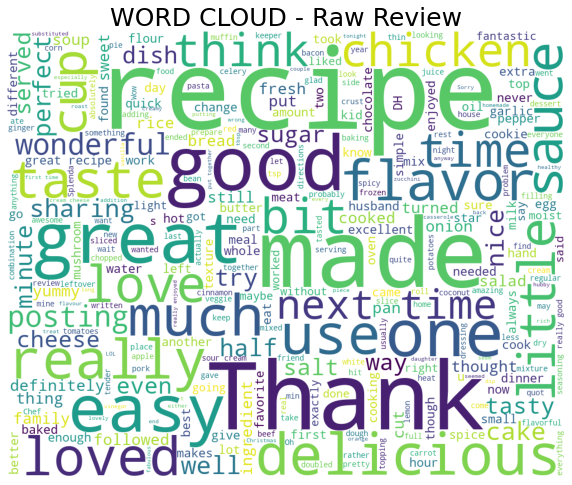

In [9]:
wordcloud = WordCloud(**word_cloud_param).generate(" ".join(raw_interact['review'].sample(1500).astype(str)))

fig = plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - Raw Review",fontsize=25)
plt.axis('off')
plt.show()

In [10]:
'''
Nettoyage de texte 
'''
%time 
raw_interact['Clean_Reviews'] = raw_interact['review'].str.lower()
raw_interact['Clean_Reviews'] = raw_interact['Clean_Reviews'].apply(remove_html_tags_func)
raw_interact['Clean_Reviews'] = raw_interact['Clean_Reviews'].apply(remove_url_func)
raw_interact['Clean_Reviews'] = raw_interact['Clean_Reviews'].apply(remove_accented_chars_func)
raw_interact['Clean_Reviews'] = raw_interact['Clean_Reviews'].apply(remove_punctuation_func)
raw_interact['Clean_Reviews'] = raw_interact['Clean_Reviews'].apply(remove_irr_char_func)
raw_interact['Clean_Reviews'] = raw_interact['Clean_Reviews'].apply(remove_extra_whitespaces_func)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


/home/minhha/Study/ModIA5/AI_techno/projet_MODIA/text_cleaning.py:76: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()
/home/minhha/Study/ModIA5/AI_techno/projet_MODIA/text_cleaning.py:76: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()


In [11]:
'''
COMPTER LE NOMBRE DE MOTS
'''

raw_interact['words_count'] = raw_interact['Clean_Reviews'].apply(word_count_func)

raw_interact[['review','Clean_Reviews', 'words_count']].sample(5)

review  \
378778  I don't know if I did something wrong while ma...   
3436    OMG this is also our Christmas Day Breakfast f...   
643424  Absolutely loved this marinade!  I did add lem...   
679786  We (at least!) doubled the horseradish as we a...   
402266  5 star\nA really tasty hamburger casserole, th...   

                                            Clean_Reviews  words_count  
378778  i don t know if i did something wrong while ma...           80  
3436    omg this is also our christmas day breakfast f...           82  
643424  absolutely loved this marinade i did add lemon...           57  
679786  we at least doubled the horseradish as we all ...           49  
402266  star a really tasty hamburger casserole the on...           19

## 2.2 Étude des commentaires de 0 notes 

<a id="2.1"></a> <br>

<div style="border-radius:10px; border:#DEB887 solid; padding: 2px; background-color: #FFFAF0; font-size:100%; text-align:left; color:black">

__David B.__ : "Faites attention aux notes à 0 elles ne correspondent pas forcément à un sentiment négatif ou positif essayez d'en regarder quelques unes et décider de toutes les supprimer si elles posent problème."

In [12]:
''' 
RECUPERER LES COMMENTAIRE ASSOCIES AUX 0
'''
rated_0 = raw_interact[raw_interact.rating==0].reset_index(drop=True)

🤔 __Remarque__
<div style="border-radius:10px; border:#DEB887 solid; padding: 2px; background-color: #FFFAF0; font-size:100%; text-align:left; color:black">

En effet, certaines recettes sont malencontreusement notées 0 même si leurs avis sont vraiment positifs.

* Les utilisateurs ont mal cliqué ?


In [13]:
rated_0.loc[rated_0.user_id ==2130022].loc[rated_0.recipe_id ==	277308]

user_id  recipe_id       date  rating  \
18078  2130022     277308 2014-01-08       0   

                                                review  \
18078  This was easy and VERY YUMMY!!  Easily 5 stars!   

                                   Clean_Reviews  words_count  
18078  this was easy and very yummy easily stars            8

💡 __Idée__
<div style="border-radius:10px; border:#DEB887 solid; padding: 1px; background-color: #FFFAF0; font-size:100%; text-align:left; color:black">

Nous décidons d'utiliser un modèle pré-entraîné de transformer Hugging Face 🤗 

pour filtrer uniquement les avis __vraiment NÉGATIFS__.

`title: "TweetEval: Unified Benchmark and Comparative Evaluation for Tweet Classification", Barbieri, Francesco, Camacho-Collados, Jose, Espinosa Anke, Luis, Neves, Leonardo`

In [14]:
'''
CHARGEMENT DE MODÈLES PRÉ-ENTRAÎNÉS
'''
from transformers import pipeline,AutoTokenizer

# model_id = "Kaludi/Reviews-Sentiment-Analysis"
# model_id = "LiYuan/amazon-review-sentiment-analysis" for rating prediction 

model_id = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_pipeline = pipeline("sentiment-analysis", model = model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
def preprocess_function(text):
    return tokenizer(text, truncation=True)['input_ids']

⚠️  __Attention__
<div style="border-radius:10px; border:#DEB887 solid; padding: 2px; background-color: #FFFAF0; font-size:100%; text-align:left; color:black">

Ce modèle pré-entraîné a une limite de longueur de tokens, donc nous allons ignorer les critiques qui ont une longue tokénisation. Heureusement, ces avis ne représentent que moins de __0,01%__ de tous les avis.  

In [16]:
'''
CALCULER la longueur des données tokenisées
'''

recalculate = False 
if recalculate:
    tokenized_rated_0 = rated_0['Clean_Reviews'].apply(preprocess_function)

    long_tokens = []
    for i in range(len(tokenized_rated_0)):
        if len(tokenized_rated_0.iloc[i]) > 512:
            long_tokens.append(i)

In [17]:
n_rates = len(rated_0)
rated_0['sentiment'] = np.zeros(n_rates)
rated_0['score_sentiment'] = np.zeros(n_rates)

In [18]:
'''
Classer les commentaires en trois catégories : négatifs, neutres et positifs. 
'''
if recalculate:
    ok_tokenization = list(set(range(n_rates)) - set(long_tokens))
    for i in ok_tokenization:
        if i%1000==0:
            print('We classified : \n', i)

        # Extract the current batch.
        clean_reviews = rated_0.loc[i, 'Clean_Reviews']

        sentiment = sentiment_pipeline(clean_reviews)
        
        rated_0.loc[i,'sentiment'] = sentiment[0]['label']
        rated_0.loc[i,'score_sentiment'] = sentiment[0]["score"]
else:
    '''CHARGER LES COMMENTAIRES CLASSIFIES '''
    rated_0 = pd.read_csv('rated_0.csv')

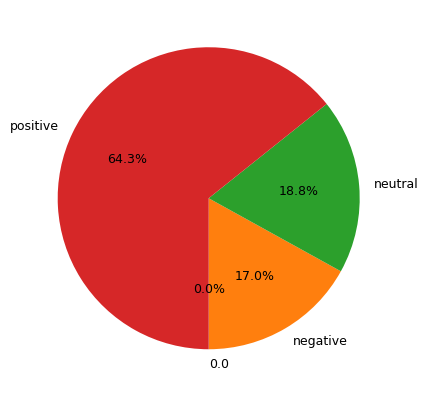

In [19]:
# Compter le nombre de commentaires par sentiment
sentiment_counts = rated_0.groupby(['sentiment']).size()

# Visualiser les sentiments
fig = plt.figure(figsize=(5,5), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=9, label="")
plt.show()

In [20]:
# Consultez les commentaires négatifs détectés 
rated_0.loc[rated_0.sentiment == "negative"].loc[rated_0.score_sentiment >= 0.9][['Clean_Reviews', 'sentiment', 'score_sentiment']].head()

Clean_Reviews sentiment  \
30  yick yick yick no one in my family of five lik...  negative   
58  not an oreo lots of time to make and very disa...  negative   
59  i did not like the taste of this recipe i feel...  negative   
71  i made this using petite sirloin steak and it ...  negative   
92  this recipe was terrible i wouldn t advise any...  negative   

    score_sentiment  
30         0.905093  
58         0.923252  
59         0.914824  
71         0.914728  
92         0.941270

In [22]:
truly_negative_0rated_reviews = rated_0.loc[rated_0.sentiment == "negative"].loc[rated_0.score_sentiment >= 0.9].reset_index(drop=True)

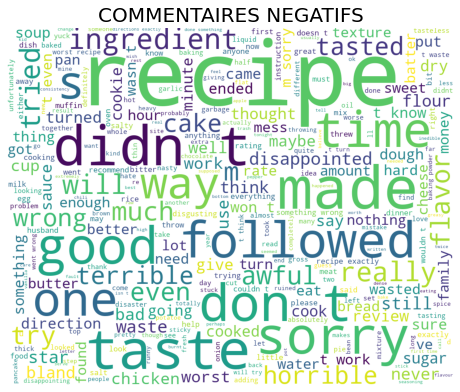

In [26]:
wordcloud = WordCloud(**word_cloud_param).generate(" ".join(truly_negative_0rated_reviews.Clean_Reviews.astype(str)))

fig = plt.figure(figsize = (8,8))
plt.imshow(wordcloud)
plt.title("COMMENTAIRES NEGATIFS",fontsize=20)
plt.axis('off')
plt.show()

In [38]:
'''
Commentaires neutres
'''
for review in rated_0.loc[rated_0.sentiment == "neutral"].loc[rated_0.score_sentiment >= 0.9][['Clean_Reviews']].values[:5]:
    print(review)

['do you have cook the potatoes beforehand']
['can you put in pint jars and let seal']
['add the sugar to the dry ingredients before cutting the butter into the flour']
['to stop your paddles from sticking in bread right after the last rise take the dough out shape it and remove your paddles then put the dough back in and continue the bake cycle']
['can you make this the night before and keep in fridge']


💡   __Observation__
<div style="border-radius:10px; border:#DEB887 solid; padding: 2px; background-color: #FFFAF0; font-size:100%; text-align:left; color:black">

Parfois, les utilisateurs veulent juste poser une question mais notent par erreur une recette 0.

In [39]:
for review in rated_0.loc[rated_0.sentiment == "positive"].loc[rated_0.score_sentiment >= 0.9][['Clean_Reviews']].values[:5]:
    print(review)

['made my own buttermilk w vinegar and milk used defrosted fresh skinless boneless chicken fillets lbs this mix is extremely flavorful and its light i didnt do the bbq thing but while i cooked homemade to go w this i put the chicken in the oven to keep warm and served bbq dipping sauce stars from my kids']
['this is a very good recipe we also want to cut back on the fat content in our diet very tasty dish']
['i made it and it was amazing']
['awesome chowder i used both canned and imitation crab the second added a lot of flavor i added old bay seasoning as well truly yummy']
['loved this salsa flavored meatloaf tang is a nice touch and so healthy']


<a id="2.3"></a> <br>

## 2.3 Préparation du jeu de données 


Toutes les notes inférieures à 4 sont négatives et celles supérieurs ou égales sont positives.


In [40]:
# TRIER LES COMMENTAIRES 
raw_interact['sentiment']  = 1* (raw_interact.rating.values > 3)
raw_interact = raw_interact.replace({'sentiment': {1: 'positive', 0: 'negative'}})
df = raw_interact.copy()
df = df[df.rating != 0].reset_index(drop=True)
df = pd.concat([df, truly_negative_0rated_reviews], ignore_index=True)
df = df[['user_id', 'recipe_id', 'date', 'rating', 'review',
          'Clean_Reviews', 'words_count', 'sentiment']]

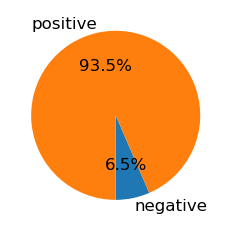

In [44]:
# Compter le nombre de commentaires par sentiment
sentiment_counts = df.groupby(['sentiment']).size()

# Visualiser les sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(121)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")
plt.show()


⚠️   __Observation__
<div style="border-radius:10px; border:#DEB887 solid; padding: 2px; background-color: #FFFAF0; font-size:100%; text-align:left; color:black">

L'ensemble de données est extrêmement déséquilibré.

In [47]:
# Divisé en deux ensembles de données, l'un pour la formation et l'autre pour le test 

from sklearn.model_selection import train_test_split
text_train, text_test, y_train, y_test = train_test_split(df.Clean_Reviews.values, df.sentiment, test_size= 0.2, 
                                                          random_state=20)

In [48]:
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
# Download stopwords list

stop_words = set(stopwords.words('english'))  | {
    "recipe",  "flour",
    "made", "food", "cup", "give", 'make', 'chicken',
    'used', 'mustard', 'pesto', 'this', 'that', 'cake'
}


# Interface lemma tokenizer from nltk with sklearn
class StemTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`', '&#039;']
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

tokenizer=StemTokenizer()

[nltk_data] Downloading package punkt to /home/minhha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/minhha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# TOKENIZER DES MOTS 
token_stop = tokenizer(' '.join(stop_words))

# Create TF-idf model
tfidf = TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer, max_features=2000)

<a id="2.4"></a> <br>

## 2.4 Construction de modèle

Étant donné que le temps d'apprentissage est de près de 2h, nous avons stocké le modèle dans un fichier pickle qui est zippé dans `pipeline_part2.tar.xz`.

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score,classification_report
import joblib

In [53]:
# IMPORTER MODELE
with open('pipeline_part2.pkl', 'rb') as fo:  
   model = joblib.load(fo)
model

In [54]:
# Prédire avec les données de test 

predictions = model.predict(text_test)


Model trained on full training dataset
Accuracy score: 0.99
Classification report 
               precision    recall  f1-score   support

    negative       0.99      0.85      0.91     14141
    positive       0.99      1.00      0.99    200524

    accuracy                           0.99    214665
   macro avg       0.99      0.92      0.95    214665
weighted avg       0.99      0.99      0.99    214665



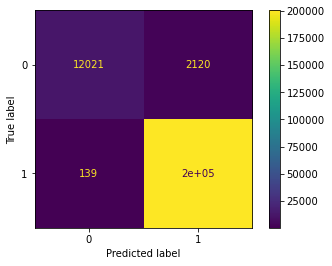

In [55]:
print('Model trained on full training dataset')
print(f"Accuracy score: {accuracy_score( y_test, predictions):.2f}")
print('Classification report \n',classification_report(y_test, predictions, labels = ['negative','positive']))
cm = confusion_matrix(y_test, predictions, labels = ['negative','positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

⚠️ __Observation__
<div style="border-radius:10px; border:#DEB887 solid; padding: 2px; background-color: #FFFAF0; font-size:100%; text-align:left; color:black">

La prédiction a un score de précision presque parfait car le modèle est formé sur une énorme quantité de commentaires positifs et peut les prédire correctement. Nous avons un certain nombre de cas de faux positifs, ce qui est supérieur aux faux négatifs. Ce n'est donc pas si mal.

<a id="2.5"></a> <br>

## 2.5 Explicabilité de modèle

In [56]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'])

In [57]:
idx = 56
exp = explainer.explain_instance(text_test[idx], model.predict_proba)
print('True class: %s' % list(y_test)[idx])
exp.show_in_notebook(text=True)

True class: negative


In [62]:
text = 'This cake is delicious. Sorry'
exp = explainer.explain_instance(text, model.predict_proba)
exp.show_in_notebook(text=True)

In [63]:
idx = 34
exp = explainer.explain_instance(text_test[idx], model.predict_proba)
print('True class: %s' % list(y_test)[idx])
exp.show_in_notebook(text=True)

True class: positive


# Partie 3: NFC

## Préparation des données

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import random
from tqdm.notebook import tqdm

In [2]:
from tqdm.notebook import tqdm

In [5]:
""" CHARGEMENT DES DONNEES """

interactions_train = pd.read_csv("data/interactions_train.csv")
interactions_test = pd.read_csv('data/interactions_test.csv')
interactions = pd.concat([interactions_train, interactions_test], ignore_index=True)

In [6]:
""" CONSTRUCTION DES JEUX D'ENTRAINEMENT ET DE TEST """

# Tous les indices de lignes de toutes les données
all_index = set(interactions.index.values)
# On tire au hasard 25% de toutes les lignes qui constitueront les données de test
index_test = random.sample(range(len(interactions)), int(len(interactions)*0.25))
# Index des données de train (= différence entre tous les index et les index de test)
index_train = list(all_index.difference(set(index_test)))

interactions_train = interactions.iloc[index_train]
interactions_test = interactions.iloc[index_test]


# Pour les données de test, on garde seulement ceux dont les user_id et 
# les recipe_id sont dans les données de train
index_to_keep = list(interactions_test.loc[(interactions_test['user_id'].isin(interactions_train['user_id'])) \
                                           & (interactions_test['recipe_id'].isin(interactions_train['recipe_id']))].\
                                            index.values)
# Et on remet ceux qui ne satisfont pas la condition dans les données de train
index_to_move_to_train = set(index_test).difference(set(index_to_keep))
# Index finaux des données de train
all_index_train = index_train + list(index_to_move_to_train)

interactions_test = interactions.iloc[index_to_keep]
interactions_train = interactions.iloc[all_index_train]

print("Pourcentage de données de test :", len(interactions_test) * 100 / (len(interactions_train) + len(interactions_test)))

Pourcentage de données de test : 21.49219237625043


## Construction du modèle

In [7]:
from torch.utils.data import Dataset, DataLoader

class Ratings_Dataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index()
        user_list = df['user_id'].unique()
        item_list = df['recipe_id'].unique()
        self.user2id = {w: i for i, w in enumerate(user_list)}
        self.item2id = {w: i for i, w in enumerate(item_list)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.user2id[self.df['user_id'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = self.item2id[self.df['recipe_id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, item, rating

trainloader = DataLoader(Ratings_Dataset(interactions_train), batch_size=512, shuffle=True ,num_workers=2)
testloader = DataLoader(Ratings_Dataset(interactions_test), batch_size=64, num_workers=2)

In [8]:
class NCF(nn.Module):

    def __init__(self, n_users, n_items, n_factors=8):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)
        self.predictor = torch.nn.Sequential(
            nn.Linear(in_features=n_factors*2, out_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, user, item):
        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concat the two embedding layers
        z = torch.cat([u, i], dim=-1)
        return self.predictor(z)

In [9]:
from statistics import mean

def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        train_loss = []
        for users, items, r in trainloader:
            users = users.cuda()
            items = items.cuda()
            r = r.cuda() / 5
            y_hat = model(users, items)
            loss = criterion(y_hat, r.unsqueeze(1).float())
            train_loss.append(loss.item())
            total += r.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss: {mean(train_loss)}")

def test(model, testloader, m_eval=False):
    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, items, r in testloader:
            users = users.cuda()
            items = items.cuda()
            y = r.cuda() / 5
            y_hat = model(users, items).flatten()
            error = torch.abs(y_hat - y).sum().data

            running_mae += error
            total += y.size(0)

    mae = running_mae/total
    return mae * 5

## Entraînement et test

In [ ]:
n_user = interactions_train.user_id.nunique()
n_items = interactions_train.recipe_id.nunique()

model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=10)

In [ ]:
test(model, testloader)

In [ ]:
users, items, r = next(iter(testloader))
users = users.cuda()
items = items.cuda()
r = r.cuda()

y = model(users, items)*5
print("ratings", r[:20].data)
print("predictions:", y.flatten()[:20].data)

In [ ]:
plt.hist(y.flatten().cpu().detach().numpy())
plt.show()

## Entraînement sur toutes les données

In [ ]:
n_user = interactions.user_id.nunique()
n_items = interactions.recipe_id.nunique()

model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=30)

In [ ]:
torch.save(model.state_dict(), "weight.pth")